# Lab 06: LIME Deep Dive

## Local Interpretable Model-agnostic Explanations

---

## Learning Objectives

By the end of this lab, you will be able to:

1. **Understand** how LIME generates explanations
2. **Apply** LIME to **regression** and **classification** problems
3. **Interpret** LIME explanations correctly
4. **Recognize** strengths and limitations of LIME
5. **Compare** LIME with SHAP

---

## What is LIME?

**LIME (Local Interpretable Model-agnostic Explanations)** explains individual predictions by approximating the complex model locally with a simple, interpretable model.

LIME essentially asks: "If I'm standing at THIS point, which direction should I move to change the model's mind?"
The answer (feature weights) tells you:
Which features matter most for THIS prediction
How much change would affect the prediction
Which direction pushes toward each class

### Core Idea

LIME asks: "What small changes would flip the prediction?"

1. **Select** a prediction to explain
2. **Perturb** the input (create similar samples nearby)
3. **Get predictions** from the black-box model for perturbed samples
4. **Weight** samples by proximity to original
5. **Fit** a simple model (e.g., linear regression) on weighted samples
6. **Use** the simple model to explain the prediction

┌─────────────────────────────────────────────────────────────┐
│  1. START: Sample to explain (e.g., patient with tumor)     │
└─────────────────────────────────────────────────────────────┘
                            │
                            ▼
┌─────────────────────────────────────────────────────────────┐
│  2. PERTURB: Create 1000 similar "fake" patients            │
│     (slightly modify feature values randomly)               │
└─────────────────────────────────────────────────────────────┘
                            │
                            ▼
┌─────────────────────────────────────────────────────────────┐
│  3. PREDICT: Ask complex model to predict each fake patient │
│     → Get 1000 predictions from black-box model             │
└─────────────────────────────────────────────────────────────┘
                            │
                            ▼
┌─────────────────────────────────────────────────────────────┐
│  4. WEIGHT: Give more importance to "fake" patients         │
│     that are closer to the original sample                  │
└─────────────────────────────────────────────────────────────┘
                            │
                            ▼
┌─────────────────────────────────────────────────────────────┐
│  5. FIT: Train simple LINEAR model on this local data       │
│     (weighted linear regression)                            │
└─────────────────────────────────────────────────────────────┘
                            │
                            ▼
┌─────────────────────────────────────────────────────────────┐
│  6. EXPLAIN: Linear model coefficients = feature importance │
└─────────────────────────────────────────────────────────────┘


### Key Properties

- **Local:** Explains one prediction at a time (not global model behavior)
- **Model-agnostic:** Works with ANY model (treats it as black-box)
- **Interpretable:** Uses simple explanation models (linear, rules)

---

## Part 1: Setup and Imports

In [28]:
# Install LIME if needed
# !pip install lime

# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_breast_cancer, fetch_california_housing
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

# LIME
import lime
import lime.lime_tabular

# Settings
np.random.seed(42)
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style('whitegrid')

print("✓ All libraries loaded successfully!")

✓ All libraries loaded successfully!


---

## Part 2: How LIME Works

### The Algorithm Visualized

```
Original Input (x)          Black-Box Model           Prediction (ŷ)
      │                           │                        │
      ▼                           │                        │
┌─────────────┐                   │                        │
│ Perturb x   │ ──── Generate ────┼──── Get predictions ───┤
│ (x₁,x₂,...) │      neighbors    │      for neighbors     │
└─────────────┘                   │                        │
      │                           │                        │
      ▼                           │                        │
┌─────────────┐                   │                        │
│ Weight by   │                   │                        │
│ proximity   │                   │                        │
└─────────────┘                   │                        │
      │                           │                        │
      ▼                           │                        │
┌─────────────┐                                            │
│ Fit simple  │ ◄─────────────────────────────────────────┘
│ linear model│
└─────────────┘
      │
      ▼
  Explanation
  (feature weights)
```

### Intuition: Local Linear Approximation

- Complex models have complex decision boundaries
- But **locally** (near one point), any function looks approximately linear
- LIME fits a linear model in this local neighborhood
- The linear coefficients become the explanation

---

---

# SECTION A: LIME for Classification

---

## Part 3: Classification Example - Breast Cancer

In [2]:
# Load data
cancer = load_breast_cancer()
X_clf = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y_clf = cancer.target  # 0=malignant, 1=benign

# Train-test split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

# Train model
clf_model = RandomForestClassifier(n_estimators=100, random_state=42)
clf_model.fit(X_train_clf, y_train_clf)

print(f"=== Breast Cancer Classification ===")
print(f"Accuracy: {clf_model.score(X_test_clf, y_test_clf):.3f}")
print(f"Classes: Malignant (0), Benign (1)")
print(f"Features: {len(X_clf.columns)}")

=== Breast Cancer Classification ===
Accuracy: 0.956
Classes: Malignant (0), Benign (1)
Features: 30


### 3.1 Create LIME Explainer

In [3]:
# Create LIME explainer for tabular data
explainer_clf = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_clf.values,           # Training data for sampling
    feature_names=X_train_clf.columns.tolist(), # Feature names
    class_names=['Malignant', 'Benign'],        # Class labels
    mode='classification'                        # Classification mode
)

print("✓ LIME explainer created!")
print("\nKey parameters:")
print("- training_data: Used to understand feature distributions")
print("- feature_names: For readable explanations")
print("- class_names: For readable class labels")
print("- mode: 'classification' or 'regression'")

✓ LIME explainer created!

Key parameters:
- training_data: Used to understand feature distributions
- feature_names: For readable explanations
- class_names: For readable class labels
- mode: 'classification' or 'regression'


### 3.2 Explain a Single Prediction

In [6]:
# Select sample to explain
sample_idx = 0
sample = X_test_clf.iloc[sample_idx].values  # Use iloc for position-based indexing

# Get model prediction
prediction = clf_model.predict([sample])[0]
proba = clf_model.predict_proba([sample])[0]
actual = y_test_clf.iloc[sample_idx] if hasattr(y_test_clf, 'iloc') else y_test_clf[sample_idx]

print(f"=== Sample {sample_idx} ===")
print(f"Actual: {'Benign' if actual else 'Malignant'}")
print(f"Predicted: {'Benign' if prediction else 'Malignant'}")
print(f"Probability - Malignant: {proba[0]:.3f}, Benign: {proba[1]:.3f}")

=== Sample 0 ===
Actual: Malignant
Predicted: Malignant
Probability - Malignant: 1.000, Benign: 0.000


/Users/sschacht/anaconda3/envs/dspy/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/sschacht/anaconda3/envs/dspy/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [7]:
# Generate LIME explanation
explanation_clf = explainer_clf.explain_instance(
    data_row=sample,                    # The sample to explain
    predict_fn=clf_model.predict_proba, # Model's prediction function
    num_features=10,                    # Number of features to show
    num_samples=1000                    # Number of perturbations
)

print("✓ LIME explanation generated!")

✓ LIME explanation generated!


/Users/sschacht/anaconda3/envs/dspy/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### 3.3 Visualize LIME Explanation

In [9]:
# Built-in visualization (in notebook) with white background
from IPython.display import display, HTML

# Set background color to white using HTML/CSS styling
display(HTML("<style>.lime{background:white !important;}</style>"))
explanation_clf.show_in_notebook(show_table=True, show_all=False)

In [10]:
# Get explanation as list
exp_list = explanation_clf.as_list()

print("=== LIME Explanation (Top Features) ===")
for feature, weight in exp_list:
    direction = "→ Benign" if weight > 0 else "→ Malignant"
    print(f"  {feature}: {weight:+.4f} {direction}")

=== LIME Explanation (Top Features) ===
  worst area > 1033.50: -0.1376 → Malignant
  worst concave points > 0.16: -0.1349 → Malignant
  worst radius > 18.55: -0.1053 → Malignant
  worst perimeter > 124.95: -0.0751 → Malignant
  mean perimeter > 103.70: -0.0633 → Malignant
  area error > 44.77: -0.0563 → Malignant
  mean concave points > 0.07: -0.0559 → Malignant
  mean radius > 15.74: -0.0558 → Malignant
  worst texture > 29.37: -0.0507 → Malignant
  worst concavity > 0.39: -0.0443 → Malignant


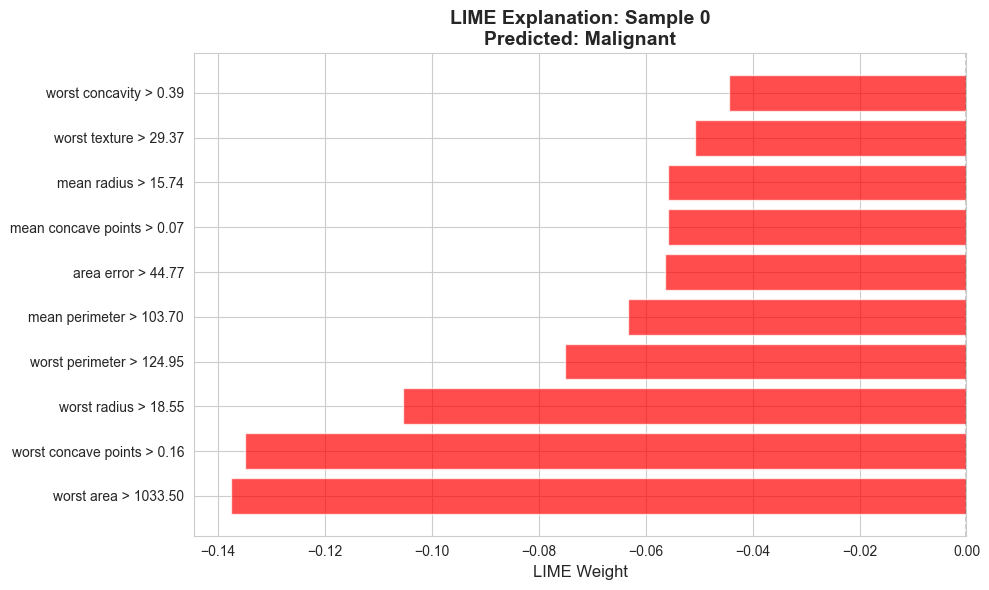

Interpretation:
- Green bars: Push towards Benign (positive class)
- Red bars: Push towards Malignant (negative class)
- Longer bars = stronger influence on this prediction


In [11]:
# Custom matplotlib visualization
features = [item[0] for item in exp_list]
weights = [item[1] for item in exp_list]
colors = ['green' if w > 0 else 'red' for w in weights]

plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), weights, color=colors, alpha=0.7)
plt.yticks(range(len(features)), features)
plt.xlabel('LIME Weight', fontsize=12)
plt.title(f'LIME Explanation: Sample {sample_idx}\nPredicted: {"Benign" if prediction else "Malignant"}', 
          fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

print("Interpretation:")
print("- Green bars: Push towards Benign (positive class)")
print("- Red bars: Push towards Malignant (negative class)")
print("- Longer bars = stronger influence on this prediction")

### 3.4 Understanding the Explanation Format

LIME shows feature conditions (not just feature names):

- `worst radius <= 14.97` means: "Given that worst radius is ≤ 14.97"
- The weight shows the contribution of this condition to the prediction
- LIME discretizes continuous features into ranges for interpretability

In [12]:
# Examine the actual feature value
print("=== Feature Values for This Sample ===")
for feature, weight in exp_list[:5]:
    # Extract feature name (before <= or >)
    feat_name = feature.split(' ')[0]
    if feat_name in X_test_clf.columns:
        val = X_test_clf.iloc[sample_idx][feat_name]
        print(f"{feat_name}: {val:.4f}")
        print(f"  Condition: {feature}")
        print(f"  Weight: {weight:+.4f}")
        print()

=== Feature Values for This Sample ===


### 3.5 Explaining Multiple Samples

/Users/sschacht/anaconda3/envs/dspy/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/sschacht/anaconda3/envs/dspy/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


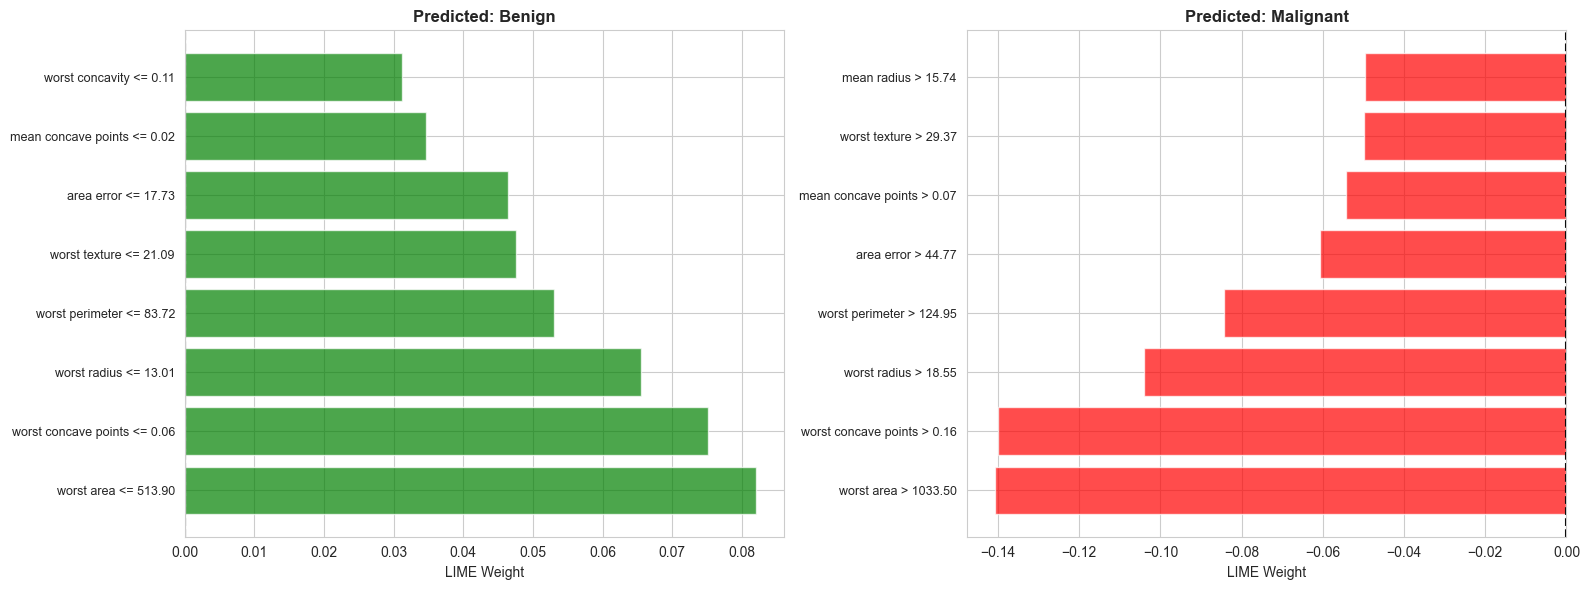

Notice how different features drive predictions for different classes!


In [29]:
# Compare explanations for Benign vs Malignant predictions

# Find one of each
y_pred = clf_model.predict(X_test_clf)
benign_idx = np.where(y_pred == 1)[0][0]
malignant_idx = np.where(y_pred == 0)[0][0]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (sample_i, title) in enumerate([(benign_idx, 'Benign'), (malignant_idx, 'Malignant')]):
    # Generate explanation
    exp = explainer_clf.explain_instance(
        X_test_clf.iloc[sample_i].values,
        clf_model.predict_proba,
        num_features=8
    )
    
    # Extract and plot
    features = [item[0] for item in exp.as_list()]
    weights = [item[1] for item in exp.as_list()]
    colors = ['green' if w > 0 else 'red' for w in weights]
    
    axes[idx].barh(range(len(features)), weights, color=colors, alpha=0.7)
    axes[idx].set_yticks(range(len(features)))
    axes[idx].set_yticklabels(features, fontsize=9)
    axes[idx].set_xlabel('LIME Weight')
    axes[idx].set_title(f'Predicted: {title}', fontweight='bold')
    axes[idx].axvline(x=0, color='black', linestyle='--')

plt.tight_layout()
plt.show()

print("Notice how different features drive predictions for different classes!")

### 3.6 Explaining Misclassified Samples

In [16]:
# Find misclassified samples
misclassified = np.where(y_pred != y_test_clf)[0]

if len(misclassified) > 0:
    error_idx = misclassified[0]
    
    print(f"=== Explaining Misclassified Sample {error_idx} ===")
    print(f"Actual: {'Benign' if y_test_clf[error_idx] else 'Malignant'}")
    print(f"Predicted: {'Benign' if y_pred[error_idx] else 'Malignant'}")
    
    # Generate explanation
    exp_error = explainer_clf.explain_instance(
        X_test_clf.iloc[error_idx].values,
        clf_model.predict_proba,
        num_features=10
    )
    
    # Visualize
    exp_error.show_in_notebook(show_table=True)
    
    print("\nThis shows which features 'fooled' the model!")
else:
    print("No misclassified samples found.")

=== Explaining Misclassified Sample 3 ===
Actual: Benign
Predicted: Malignant


/Users/sschacht/anaconda3/envs/dspy/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



This shows which features 'fooled' the model!


---

# SECTION B: LIME for Regression

---

## Part 4: Regression Example - California Housing

In [17]:
# Load data
housing = fetch_california_housing()
X_reg = pd.DataFrame(housing.data, columns=housing.feature_names)
y_reg = housing.target

# Train-test split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Train model
reg_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
reg_model.fit(X_train_reg, y_train_reg)

# Evaluate
y_pred_reg = reg_model.predict(X_test_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print(f"=== California Housing Regression ===")
print(f"R² Score: {r2:.3f}")
print(f"Features: {list(X_reg.columns)}")

=== California Housing Regression ===
R² Score: 0.774
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


### 4.1 Create LIME Explainer for Regression

In [18]:
# Create LIME explainer (mode='regression')
explainer_reg = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_reg.values,
    feature_names=X_train_reg.columns.tolist(),
    mode='regression'  # Key difference!
)

print("✓ LIME explainer for regression created!")

✓ LIME explainer for regression created!


### 4.2 Explain a Regression Prediction

In [20]:
# Select sample
sample_idx = 0
sample_reg = X_test_reg.iloc[sample_idx].values

# Get prediction
prediction_reg = reg_model.predict([sample_reg])[0]
# Fix: y_test_reg may be a numpy array, so use standard indexing
if hasattr(y_test_reg, "iloc"):
    actual_reg = y_test_reg.iloc[sample_idx]
else:
    actual_reg = y_test_reg[sample_idx]

print(f"=== Sample {sample_idx} ===")
print(f"Actual price: ${actual_reg * 100000:,.0f}")
print(f"Predicted price: ${prediction_reg * 100000:,.0f}")
print(f"\nFeature values:")
for feat, val in zip(X_test_reg.columns, sample_reg):
    print(f"  {feat}: {val:.2f}")

=== Sample 0 ===
Actual price: $47,700
Predicted price: $56,803

Feature values:
  MedInc: 1.68
  HouseAge: 25.00
  AveRooms: 4.19
  AveBedrms: 1.02
  Population: 1392.00
  AveOccup: 3.88
  Latitude: 36.06
  Longitude: -119.01


/Users/sschacht/anaconda3/envs/dspy/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [21]:
# Generate explanation
explanation_reg = explainer_reg.explain_instance(
    data_row=sample_reg,
    predict_fn=reg_model.predict,  # Note: .predict, not .predict_proba
    num_features=8
)

# Visualize
explanation_reg.show_in_notebook(show_table=True)

/Users/sschacht/anaconda3/envs/dspy/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


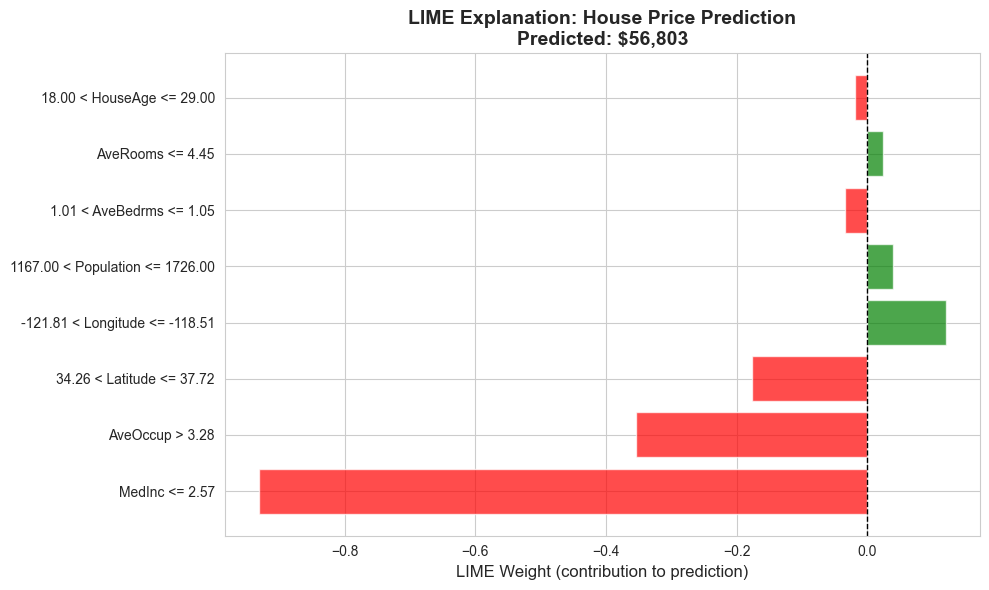

Interpretation:
- Green: Feature increases predicted price
- Red: Feature decreases predicted price
- Intercept (baseline): 2.5907


In [22]:
# Custom visualization
exp_list_reg = explanation_reg.as_list()
features = [item[0] for item in exp_list_reg]
weights = [item[1] for item in exp_list_reg]
colors = ['green' if w > 0 else 'red' for w in weights]

plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), weights, color=colors, alpha=0.7)
plt.yticks(range(len(features)), features)
plt.xlabel('LIME Weight (contribution to prediction)', fontsize=12)
plt.title(f'LIME Explanation: House Price Prediction\nPredicted: ${prediction_reg * 100000:,.0f}', 
          fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

print("Interpretation:")
print("- Green: Feature increases predicted price")
print("- Red: Feature decreases predicted price")
print(f"- Intercept (baseline): {explanation_reg.intercept[0]:.4f}")

### 4.3 Compare High vs Low Value Predictions

/Users/sschacht/anaconda3/envs/dspy/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sschacht/anaconda3/envs/dspy/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sschacht/anaconda3/envs/dspy/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sschacht/anaconda3/envs/dspy/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


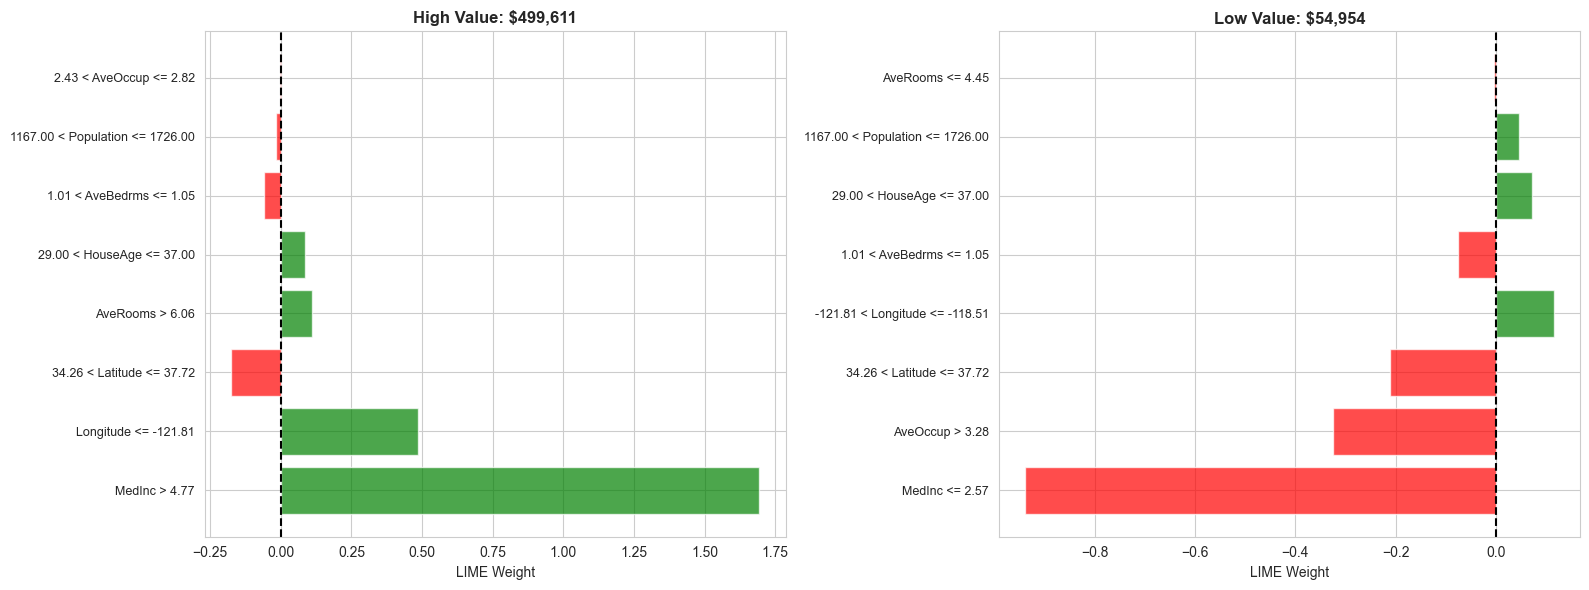

Compare which features drive high vs low house prices!


In [23]:
# Find high and low predictions
high_idx = np.argmax(y_pred_reg)
low_idx = np.argmin(y_pred_reg)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (sample_i, title) in enumerate([(high_idx, 'High Value'), (low_idx, 'Low Value')]):
    pred = reg_model.predict([X_test_reg.iloc[sample_i].values])[0]
    
    exp = explainer_reg.explain_instance(
        X_test_reg.iloc[sample_i].values,
        reg_model.predict,
        num_features=8
    )
    
    features = [item[0] for item in exp.as_list()]
    weights = [item[1] for item in exp.as_list()]
    colors = ['green' if w > 0 else 'red' for w in weights]
    
    axes[idx].barh(range(len(features)), weights, color=colors, alpha=0.7)
    axes[idx].set_yticks(range(len(features)))
    axes[idx].set_yticklabels(features, fontsize=9)
    axes[idx].set_xlabel('LIME Weight')
    axes[idx].set_title(f'{title}: ${pred * 100000:,.0f}', fontweight='bold')
    axes[idx].axvline(x=0, color='black', linestyle='--')

plt.tight_layout()
plt.show()

print("Compare which features drive high vs low house prices!")

---

## Part 6: LIME Strengths and Limitations

---

### Strengths ✓

1. **Model-agnostic:** Works with ANY model (neural networks, ensemble methods, etc.)
2. **Intuitive:** Linear explanations are easy to understand
3. **Fast:** Quick to generate explanations
4. **Flexible:** Can explain any prediction type
5. **Human-readable:** Discretization creates interpretable conditions

### Limitations ✗

1. **Instability:** Different runs can give different explanations
2. **Local only:** Doesn't explain global model behavior
3. **Sampling dependency:** Quality depends on perturbation strategy
4. **Can be manipulated:** Adversarial examples can fool LIME
5. **Assumes locality:** May not work well for highly non-linear boundaries

---

In [ ]:
# Demonstrate instability
print("=== LIME Instability Demo ===")
print("Running LIME 5 times on same sample...\n")

sample = X_test_clf.iloc[0].values
top_features = []

for i in range(5):
    exp = explainer_clf.explain_instance(
        sample,
        clf_model.predict_proba,
        num_features=5,
        num_samples=500  # Lower samples = more instability
    )
    top = [item[0] for item in exp.as_list()[:3]]
    top_features.append(top)
    print(f"Run {i+1}: {top}")

print("\n⚠️ Notice: Top features may vary between runs!")
print("This is a known limitation of LIME.")
print("Increase num_samples for more stability.")

---

## Part 7: LIME vs SHAP Comparison

---

### Feature Comparison

| Aspect | LIME | SHAP |
|--------|------|------|
| **Approach** | Local linear approximation | Shapley values (game theory) |
| **Scope** | Local only | Local + Global |
| **Theoretical basis** | Heuristic | Theoretically grounded |
| **Stability** | Less stable | More stable |
| **Speed** | Fast | Varies (TreeExplainer fast) |
| **Model-agnostic** | Yes | Yes (KernelExplainer) |
| **Additivity** | No guarantee | Values sum to prediction |

### When to Use Which?

**Use LIME when:**
- You need quick, local explanations
- Working with any model type
- Interpretable conditions matter ("age > 50")
- Speed is critical

**Use SHAP when:**
- You need theoretical guarantees
- Global explanations are needed
- Stability is important
- Using tree-based models (TreeExplainer is fast)

**Best Practice:** Use both and compare!

In [ ]:
# Quick comparison: LIME vs SHAP on same sample
import shap

sample = X_test_clf.iloc[0].values
sample_df = X_test_clf.iloc[[0]]

# LIME explanation
lime_exp = explainer_clf.explain_instance(sample, clf_model.predict_proba, num_features=8)
lime_features = [item[0].split(' ')[0] for item in lime_exp.as_list()]

# SHAP explanation
shap_explainer = shap.TreeExplainer(clf_model)
shap_values = shap_explainer.shap_values(sample_df)
shap_importance = np.abs(shap_values[1][0])
shap_top_idx = np.argsort(shap_importance)[-8:][::-1]
shap_features = [X_test_clf.columns[i] for i in shap_top_idx]

print("=== Top Features Comparison ===")
print(f"\nLIME top features:")
for i, f in enumerate(lime_features[:5], 1):
    print(f"  {i}. {f}")

print(f"\nSHAP top features:")
for i, f in enumerate(shap_features[:5], 1):
    print(f"  {i}. {f}")

# Check overlap
lime_set = set(lime_features[:5])
shap_set = set(shap_features[:5])
overlap = lime_set.intersection(shap_set)
print(f"\nOverlap: {len(overlap)}/5 features")
print(f"Common features: {overlap}")

---

## Part 8: Practical Applications of LIME

---

### 🔍 1. Debugging Model Errors

When your model makes a wrong prediction:
1. Generate LIME explanation for the error
2. Identify which features "fooled" the model
3. Check if feature values are unusual
4. Decide: Bad model or bad data?

### 📝 2. Stakeholder Communication

LIME's discretized explanations are very readable:
- "This loan was rejected because income < $40k AND debt_ratio > 0.5"
- Non-technical stakeholders can understand and verify

### ⚖️ 3. Regulatory Compliance

For "right to explanation" requirements:
- Generate LIME explanation for each decision
- Store explanations with predictions
- Provide to customers on request

### 🧪 4. Model Validation

Sanity-check your model:
- Do explanations make domain sense?
- Are important features what you expect?
- Any surprising patterns?

---

## Summary

### What You Learned

1. ✓ **How LIME works:** Local linear approximation of complex models
2. ✓ **LIME for classification:** Breast cancer diagnosis example
3. ✓ **LIME for regression:** House price prediction example
4. ✓ **Key parameters:** num_samples, num_features, discretization
5. ✓ **Strengths:** Fast, model-agnostic, interpretable
6. ✓ **Limitations:** Instability, local only
7. ✓ **LIME vs SHAP:** When to use each

### Key Takeaways

- LIME explains predictions by fitting a local linear model
- Works with ANY model (treats it as black-box)
- Great for quick, interpretable explanations
- Be aware of instability - increase num_samples
- Use alongside SHAP for comprehensive analysis

### Best Practices

**DO ✓**
- Use enough samples (num_samples ≥ 1000)
- Validate explanations make domain sense
- Compare with SHAP for important decisions
- Document parameters used

**DON'T ✗**
- Trust a single LIME explanation blindly
- Use for global model understanding (LIME is local!)
- Interpret weights as causal effects
- Forget to set random seed for reproducibility

---

**LIME is your go-to tool for quick, interpretable explanations of any model!**

**Happy explaining!** 🎯